In [1]:
#PreProcessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
import joblib
import warnings
warnings.filterwarnings('ignore')
#Feature Engineering
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from xgboost import XGBClassifier        # recommended for feature importance
from catboost import CatBoostClassifier  # optional alternative, handles categorical features natively
#visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap

# Preprocessing

### Outlier Handling

In [2]:
df = pd.read_csv("D:/Machine Learning Projects/3. Rain Predictor/0_rain.csv")

In [3]:
# Convert datetime column to pandas datetime object
df["datetime"] = pd.to_datetime(df["datetime"], format="%Y-%m-%d:%H")
# Extract useful time-based features
df["year"] = df["datetime"].dt.year
df["month"] = df["datetime"].dt.month
df["day"] = df["datetime"].dt.day
df["hour"] = df["datetime"].dt.hour
df["day_of_week"] = df["datetime"].dt.dayofweek  # Monday=0, Sunday=6
# Cyclical encoding for month and hour
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
# After extracting, you can drop the original datetime if you want
df = df.drop(columns=["datetime", "ts", "timestamp_utc", "timestamp_local","solar_rad","ghi","dhi"])

In [4]:
df.head()

,slp,dewpt,uv,wind_dir,precip,pop,ozone,app_temp,clouds_low,clouds_mid,...,lat,year,month,day,hour,day_of_week,month_sin,month_cos,hour_sin,hour_cos
0,1002.0,78.6,0.0,233,0.000,0,289.5,102.9,59,0,...,24.8607,2024,6,14,18,4,1.224647e-16,-1.0,-1.000000,-1.836970e-16
1,1000.5,79.1,0.0,241,0.000,15,286.0,102.6,80,0,...,24.8607,2024,6,14,21,4,1.224647e-16,-1.0,-0.707107,7.071068e-01
2,1000.5,79.2,0.0,236,0.001,15,288.5,101.5,62,0,...,24.8607,2024,6,15,0,5,1.224647e-16,-1.0,0.000000,1.000000e+00
3,1002.5,79.2,2.8,237,0.000,0,288.8,104.1,68,0,...,24.8607,2024,6,15,3,5,1.224647e-16,-1.0,0.707107,7.071068e-01
4,1002.0,77.9,9.8,236,0.000,0,286.5,109.2,47,0,...,24.8607,2024,6,15,6,5,1.224647e-16,-1.0,1.000000,6.123234e-17


In [5]:
# Step 1: Map wind_cdir (short codes) → degrees
direction_map = {
    "N": 0, "NNE": 22.5, "NE": 45, "ENE": 67.5,
    "E": 90, "ESE": 112.5, "SE": 135, "SSE": 157.5,
    "S": 180, "SSW": 202.5, "SW": 225, "WSW": 247.5,
    "W": 270, "WNW": 292.5, "NW": 315, "NNW": 337.5
}

df["wind_deg"] = df["wind_cdir"].map(direction_map)

# Step 2: Handle any missing or unexpected values
df["wind_deg"] = df["wind_deg"].fillna(-1)   # -1 means unknown

# Step 3: Cyclical encoding (convert degrees → sin & cos)
df["wind_sin"] = np.sin(2 * np.pi * df["wind_deg"] / 360)
df["wind_cos"] = np.cos(2 * np.pi * df["wind_deg"] / 360)

# Step 4: Drop original text columns (since redundant)
df = df.drop(columns=["wind_cdir", "wind_cdir_full"])

In [6]:
df.head()

,slp,dewpt,uv,wind_dir,precip,pop,ozone,app_temp,clouds_low,clouds_mid,...,day,hour,day_of_week,month_sin,month_cos,hour_sin,hour_cos,wind_deg,wind_sin,wind_cos
0,1002.0,78.6,0.0,233,0.000,0,289.5,102.9,59,0,...,14,18,4,1.224647e-16,-1.0,-1.000000,-1.836970e-16,225.0,-0.707107,-0.707107
1,1000.5,79.1,0.0,241,0.000,15,286.0,102.6,80,0,...,14,21,4,1.224647e-16,-1.0,-0.707107,7.071068e-01,247.5,-0.923880,-0.382683
2,1000.5,79.2,0.0,236,0.001,15,288.5,101.5,62,0,...,15,0,5,1.224647e-16,-1.0,0.000000,1.000000e+00,225.0,-0.707107,-0.707107
3,1002.5,79.2,2.8,237,0.000,0,288.8,104.1,68,0,...,15,3,5,1.224647e-16,-1.0,0.707107,7.071068e-01,247.5,-0.923880,-0.382683
4,1002.0,77.9,9.8,236,0.000,0,286.5,109.2,47,0,...,15,6,5,1.224647e-16,-1.0,1.000000,6.123234e-17,225.0,-0.707107,-0.707107


In [7]:
print(df['icon'].unique())

['c02n' 'c02d' 'c01n' 'c01d' 'c04d' 'c04n' 'r04d' 'c03n' 'r04n' 't02n'
 'c03d']


In [8]:
# Drop the icon column (not useful)
df = df.drop(columns=["icon"], errors="ignore")

# Direct mapping of weather codes into categories
df["weather_category"] = df["code"].map({
    800: "clear",
    801: "clouds",
    802: "clouds",
    803: "clouds",
    804: "clouds",
    520: "rain",
    201: "thunderstorm"
}).fillna("other")

# (Optional) drop the raw code column if you don’t want it anymore
df = df.drop(columns=["code"])

In [9]:
df.head()

,slp,dewpt,uv,wind_dir,precip,pop,ozone,app_temp,clouds_low,clouds_mid,...,hour,day_of_week,month_sin,month_cos,hour_sin,hour_cos,wind_deg,wind_sin,wind_cos,weather_category
0,1002.0,78.6,0.0,233,0.000,0,289.5,102.9,59,0,...,18,4,1.224647e-16,-1.0,-1.000000,-1.836970e-16,225.0,-0.707107,-0.707107,clouds
1,1000.5,79.1,0.0,241,0.000,15,286.0,102.6,80,0,...,21,4,1.224647e-16,-1.0,-0.707107,7.071068e-01,247.5,-0.923880,-0.382683,clouds
2,1000.5,79.2,0.0,236,0.001,15,288.5,101.5,62,0,...,0,5,1.224647e-16,-1.0,0.000000,1.000000e+00,225.0,-0.707107,-0.707107,clouds
3,1002.5,79.2,2.8,237,0.000,0,288.8,104.1,68,0,...,3,5,1.224647e-16,-1.0,0.707107,7.071068e-01,247.5,-0.923880,-0.382683,clouds
4,1002.0,77.9,9.8,236,0.000,0,286.5,109.2,47,0,...,6,5,1.224647e-16,-1.0,1.000000,6.123234e-17,225.0,-0.707107,-0.707107,clouds


In [10]:
df = df.drop(columns=["description"])

In [11]:
missing_values = df.isna().sum()
print(missing_values)

slp                 0
dewpt               0
uv                  0
wind_dir            0
precip              0
pop                 0
ozone               0
app_temp            0
clouds_low          0
clouds_mid          0
snow_depth          0
wind_gust_spd       0
dni                 0
rh                  0
pod                 0
pres                0
snow                0
temp                0
clouds              0
vis                 0
clouds_hi           0
wind_spd            0
city                0
country             0
lon                 0
lat                 0
year                0
month               0
day                 0
hour                0
day_of_week         0
month_sin           0
month_cos           0
hour_sin            0
hour_cos            0
wind_deg            0
wind_sin            0
wind_cos            0
weather_category    0
dtype: int64


In [12]:
pd.set_option("display.max_columns", None)
min_max_values = df.aggregate(['min','max'])
print(min_max_values)

        slp  dewpt    uv  wind_dir  precip  pop  ozone  app_temp  clouds_low  \
min   822.3   19.0   0.0         1   0.000    0  274.0      39.9           0   
max  1020.5   81.1  10.5       360   0.071   65  308.3     124.4          80   

     clouds_mid  snow_depth  wind_gust_spd     dni  rh pod    pres  snow  \
min           0           0            1.1    0.00   4   d   634.5     0   
max         100           0           34.5  943.14  88   n  1003.0     0   

      temp  clouds   vis  clouds_hi  wind_spd        city   country      lon  \
min   42.6       0   4.0          0       0.2  Bahāwalpur  Pakistan  63.0383   
max  117.4     100  14.9        100      28.2         Tāl  Pakistan  75.5510   

         lat  year  month  day  hour  day_of_week     month_sin  month_cos  \
min  24.8607  2024      6   14     0            0  1.224647e-16       -1.0   
max  35.3247  2024      6   19    21            6  1.224647e-16       -1.0   

     hour_sin  hour_cos  wind_deg  wind_sin  wind_cos 

In [13]:
# Convert Fahrenheit to Celsius
df["temp"] = (df["temp"] - 32) * 5.0/9.0
df["app_temp"] = (df["app_temp"] - 32) * 5.0/9.0

In [14]:
df["hour_cos"].agg(['min', 'max'])

min   -1.0
max    1.0
Name: hour_cos, dtype: float64

In [15]:
# Calculate mean (only for valid range, 870–1080)
mean_slp = df.loc[(df['slp'] >= 870) & (df['slp'] <= 1080), 'slp'].mean()
# Replace outliers with mean
df.loc[(df['slp'] < 870) | (df['slp'] > 1080), 'slp'] = np.ceil(mean_slp)

In [16]:
# Convert precip from meters to millimeters
df['precip'] = df['precip'] * 1000

In [17]:
df['pres'] = df['pres'].clip(lower=900, upper=1050)

In [18]:
# Fix unrealistic dewpoint values (clip between 0 and 35 °C)
df['dewpt'] = np.clip(df['dewpt'], 0, 35)
# Optional: Handle extreme precipitation (clip at 60 mm/h to avoid rare spikes)
df['precip'] = np.clip(df['precip'], 0, 60)

In [19]:
df.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
715    False
716    False
717    False
718    False
719    False
Length: 720, dtype: bool

In [20]:
# Drop useless columns
df = df.drop(columns=["snow", "snow_depth"])

### Encoding

In [21]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoded = encoder.fit_transform(df[["city", "country", "weather_category"]])

df = df.drop(["city", "country", "weather_category"], axis=1).join(
    pd.DataFrame(encoded, columns=encoder.get_feature_names_out())
)

joblib.dump(encoder, "D:/Machine Learning Projects/3. Rain Predictor/one_hot_encoder.pkl")

['D:/Machine Learning Projects/3. Rain Predictor/one_hot_encoder.pkl']

In [22]:
le_pod = LabelEncoder()
df['pod'] = le_pod.fit_transform(df['pod'])

In [23]:
joblib.dump(le_pod, "D:/Machine Learning Projects/3. Rain Predictor/label_encoder.pkl")

['D:/Machine Learning Projects/3. Rain Predictor/label_encoder.pkl']

In [24]:
print(df['hour_cos'].unique())

[-1.83697020e-16  7.07106781e-01  1.00000000e+00  7.07106781e-01
  6.12323400e-17 -7.07106781e-01 -1.00000000e+00 -7.07106781e-01]


In [25]:
df["rainfall"] = (df["precip"] > 0).astype(int)

In [26]:
df.head()

,slp,dewpt,uv,wind_dir,precip,pop,ozone,app_temp,clouds_low,clouds_mid,wind_gust_spd,dni,rh,pod,pres,temp,clouds,vis,clouds_hi,wind_spd,lon,lat,year,month,day,hour,day_of_week,month_sin,month_cos,hour_sin,hour_cos,wind_deg,wind_sin,wind_cos,city_Bahāwalpur,city_Faisalābād,city_Gujrānwāla,city_Hyderabad,city_Islamabad,city_Karachi,city_Lahore,city_Mandi Bahāuddīn,city_Miānwāli,city_Multān,city_Peshawar,city_Quetta,city_Sargodha,city_Sheikhupura,city_Sialkot,city_Skārdu,city_Turbat,city_Tāl,country_Pakistan,weather_category_clear,weather_category_clouds,weather_category_rain,weather_category_thunderstorm,rainfall
0,1002.0,35.0,0.0,233,0.0,0,289.5,39.388889,59,0,12.3,0.00,73,1,1001.5,31.277778,54,14.9,0,10.4,67.0011,24.8607,2024,6,14,18,4,1.224647e-16,-1.0,-1.000000,-1.836970e-16,225.0,-0.707107,-0.707107,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0
1,1000.5,35.0,0.0,241,0.0,15,286.0,39.222222,80,0,12.7,0.00,76,1,1000.5,30.888889,53,14.9,0,8.1,67.0011,24.8607,2024,6,14,21,4,1.224647e-16,-1.0,-0.707107,7.071068e-01,247.5,-0.923880,-0.382683,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0
2,1000.5,35.0,0.0,236,1.0,15,288.5,38.611111,62,0,14.2,0.00,78,1,1000.5,30.500000,57,14.9,0,8.1,67.0011,24.8607,2024,6,15,0,5,1.224647e-16,-1.0,0.000000,1.000000e+00,225.0,-0.707107,-0.707107,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1
3,1002.5,35.0,2.8,237,0.0,0,288.8,40.055556,68,0,14.1,742.95,74,0,1002.5,31.388889,57,14.9,0,6.9,67.0011,24.8607,2024,6,15,3,5,1.224647e-16,-1.0,0.707107,7.071068e-01,247.5,-0.923880,-0.382683,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0
4,1002.0,35.0,9.8,236,0.0,0,286.5,42.888889,47,0,15.0,917.15,61,0,1002.0,34.111111,58,14.9,0,9.2,67.0011,24.8607,2024,6,15,6,5,1.224647e-16,-1.0,1.000000,6.123234e-17,225.0,-0.707107,-0.707107,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0


In [27]:
df["hour_cos"] = df["hour_cos"].round(6)
df["hour_sin"] = df["hour_sin"].round(6)
df["month_sin"] = df["hour_sin"].round(6)

In [28]:
df = df.drop(["month", "hour","day","day_of_week"], axis=1)

In [29]:
df.to_csv('D:/Machine Learning Projects/3. Rain Predictor/1_Encoded_rain.csv',index=False)

In [63]:
df_encod = pd.read_csv('C:/Users/Sultan/Downloads/ML/weather forecasting/1_Encoded_rain.csv')

In [64]:
df_encod.head()

,solar_rad,slp,dewpt,uv,wind_dir,ghi,dhi,precip,pop,ozone,app_temp,clouds_low,clouds_mid,wind_gust_spd,dni,rh,pod,pres,temp,clouds,vis,clouds_hi,wind_spd,lon,lat,year,month_sin,month_cos,hour_sin,hour_cos,wind_deg,wind_sin,wind_cos,city_Bahāwalpur,city_Faisalābād,city_Gujrānwāla,city_Hyderabad,city_Islamabad,city_Karachi,city_Lahore,city_Mandi Bahāuddīn,city_Miānwāli,city_Multān,city_Peshawar,city_Quetta,city_Sargodha,city_Sheikhupura,city_Sialkot,city_Skārdu,city_Turbat,city_Tāl,country_Pakistan,weather_category_clear,weather_category_clouds,weather_category_rain,weather_category_thunderstorm,rainfall
0,0.00000,1002.0,35.0,0.0,233,0.00,0.00,0.0,0,289.5,39.388889,59,0,12.3,0.00,73,1,1001.5,31.277778,54,14.9,0,10.4,67.0011,24.8607,2024,-1.000000,-1.0,-1.000000,-0.000000,225.0,-0.707107,-0.707107,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0
1,0.00000,1000.5,35.0,0.0,241,0.00,0.00,0.0,15,286.0,39.222222,80,0,12.7,0.00,76,1,1000.5,30.888889,53,14.9,0,8.1,67.0011,24.8607,2024,-0.707107,-1.0,-0.707107,0.707107,247.5,-0.923880,-0.382683,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0
2,0.00000,1000.5,35.0,0.0,236,0.00,0.00,1.0,15,288.5,38.611111,62,0,14.2,0.00,78,1,1000.5,30.500000,57,14.9,0,8.1,67.0011,24.8607,2024,0.000000,-1.0,0.000000,1.000000,225.0,-0.707107,-0.707107,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1
3,398.55627,1002.5,35.0,2.8,237,436.35,88.85,0.0,0,288.8,40.055556,68,0,14.1,742.95,74,0,1002.5,31.388889,57,14.9,0,6.9,67.0011,24.8607,2024,0.707107,-1.0,0.707107,0.707107,247.5,-0.923880,-0.382683,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0
4,886.52090,1002.0,35.0,9.8,236,968.79,122.16,0.0,0,286.5,42.888889,47,0,15.0,917.15,61,0,1002.0,34.111111,58,14.9,0,9.2,67.0011,24.8607,2024,1.000000,-1.0,1.000000,0.000000,225.0,-0.707107,-0.707107,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0


In [30]:
numeric_features = [
     "slp", "dewpt", "uv", "precip","pop", 
    "ozone", "app_temp","clouds_low","clouds_mid", "wind_gust_spd", "dni", "rh", "pres", 
    "temp", "clouds", "vis", "wind_spd","lon","lat","wind_deg","wind_dir"
]

In [31]:
df = df.drop(['year'],axis=1)

### Scaling

In [32]:
df_scaled = df.copy()
standard_scaler = StandardScaler()
df_scaled[numeric_features] = standard_scaler.fit_transform(df_scaled[numeric_features])

In [33]:
df_scaled.head()

,slp,dewpt,uv,wind_dir,precip,pop,ozone,app_temp,clouds_low,clouds_mid,wind_gust_spd,dni,rh,pod,pres,temp,clouds,vis,clouds_hi,wind_spd,lon,lat,month_sin,month_cos,hour_sin,hour_cos,wind_deg,wind_sin,wind_cos,city_Bahāwalpur,city_Faisalābād,city_Gujrānwāla,city_Hyderabad,city_Islamabad,city_Karachi,city_Lahore,city_Mandi Bahāuddīn,city_Miānwāli,city_Multān,city_Peshawar,city_Quetta,city_Sargodha,city_Sheikhupura,city_Sialkot,city_Skārdu,city_Turbat,city_Tāl,country_Pakistan,weather_category_clear,weather_category_clouds,weather_category_rain,weather_category_thunderstorm,rainfall
0,0.645640,0.265971,-0.791098,0.387508,-0.180781,-0.276502,-0.293695,0.295985,3.437158,-0.518372,0.036598,-0.996239,1.852337,1,1.312500,-0.331453,1.759912,0.146721,0,1.068008,-1.456083,-2.103807,-1.000000,-1.0,-1.000000,-0.000000,0.309989,-0.707107,-0.707107,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0
1,0.475826,0.265971,-0.791098,0.479079,-0.180781,1.797264,-0.878623,0.278430,4.792834,-0.518372,0.101065,-0.996239,2.017363,1,1.279641,-0.376954,1.716945,0.146721,0,0.478880,-1.456083,-2.103807,-0.707107,-1.0,-0.707107,0.707107,0.568612,-0.923880,-0.382683,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0
2,0.475826,0.265971,-0.791098,0.421847,0.027146,1.797264,-0.460817,0.214063,3.630826,-0.518372,0.342816,-0.996239,2.127380,1,1.279641,-0.422455,1.888813,0.146721,0,0.478880,-1.456083,-2.103807,0.000000,-1.0,0.000000,1.000000,0.309989,-0.707107,-0.707107,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1
3,0.702245,0.265971,-0.054955,0.433293,-0.180781,-0.276502,-0.410680,0.366204,4.018162,-0.518372,0.326699,0.805955,1.907346,0,1.345360,-0.318453,1.888813,0.146721,0,0.171509,-1.456083,-2.103807,0.707107,-1.0,0.707107,0.707107,0.568612,-0.923880,-0.382683,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0
4,0.645640,0.265971,1.785403,0.421847,-0.180781,-0.276502,-0.795062,0.664635,2.662486,-0.518372,0.471750,1.228517,1.192235,0,1.328930,0.000054,1.931780,0.146721,0,0.760637,-1.456083,-2.103807,1.000000,-1.0,1.000000,0.000000,0.309989,-0.707107,-0.707107,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0


In [34]:
print(df_scaled['clouds_low'].unique())

[ 3.43715799  4.79283372  3.63082595  4.01816187  2.66248615  2.53337418
  2.14603826  3.11437806  2.59793016  4.08271786  3.17893405  3.37260201
  1.37136641  2.08148227  2.72704214  2.33970622  2.21059424  3.04982207
  2.4042622   4.53460977  1.75870234  1.88781431  0.59669457  2.9207101
  2.79159812  2.85615411  1.9523703  -0.37164523  0.14480266  0.79036253
  2.01692628  1.82325832  3.30804602  4.34094181  0.08024668  1.24225444
  1.30681043  2.98526609  3.56626997  2.27515023  1.62959036  1.56503438
  3.50171398  2.46881819  1.11314247  0.85491852  3.69538194  1.04858648
 -0.0488653  -0.11342128 -0.30708924  0.01569069  0.53213859  0.66125056]


In [35]:
joblib.dump(standard_scaler, "D:/Machine Learning Projects/3. Rain Predictor/standard_scaler.pkl")

['D:/Machine Learning Projects/3. Rain Predictor/standard_scaler.pkl']

In [36]:
df_scaled.to_csv('D:/Machine Learning Projects/3. Rain Predictor/1_prep_rain.csv',index=False)

In [37]:
df_scaled = pd.read_csv('C:/Users/Sultan/Downloads/ML/weather forecasting/1_prep_rain.csv')

In [37]:
y = df_scaled['rainfall']  
print(y.value_counts())

rainfall
0    660
1     60
Name: count, dtype: int64


In [38]:
X = df_scaled.drop(columns=['rainfall'], axis = 1)

In [39]:
smote = SMOTE(random_state=42)
X_res,y_res = smote.fit_resample(X,y)

In [40]:
df_resampled = pd.DataFrame(X_res, columns=X.columns)
df_resampled['rainfall'] = y_res

In [41]:
print(df_resampled['rainfall'].value_counts())

rainfall
0    660
1    660
Name: count, dtype: int64


In [53]:
df_resampled.to_csv('D:/Machine Learning Projects/3. Rain Predictor/2_syn_rain_1.csv',index=False)

### Feature Engineering

In [44]:
df_resampled = pd.read_csv("C:/Users/Sultan/Downloads/ML/weather forecasting/2_syn_rain.csv")

In [43]:
X = df_resampled.drop(columns=['rainfall'],axis=1)
y = df_resampled['rainfall']

In [44]:
fi_model = RandomForestClassifier()
fi_model.fit(X,y)

RandomForestClassifier()

In [45]:
# Get feature importance
importances = fi_model.feature_importances_
feat_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_importance.to_string(index=False))

                      Feature  Importance
                       precip    0.331618
                          pop    0.306652
                   clouds_mid    0.065970
                    clouds_hi    0.049384
                       clouds    0.026711
       weather_category_clear    0.021777
      weather_category_clouds    0.021776
                     wind_cos    0.015267
                     app_temp    0.014802
                          lat    0.013671
                         temp    0.013220
                         pres    0.012554
                           rh    0.008358
                     city_Tāl    0.007396
                          lon    0.007162
                     wind_sin    0.007058
                          vis    0.006328
                     wind_dir    0.005397
        weather_category_rain    0.005171
                          slp    0.004717
                        ozone    0.004617
                     hour_sin    0.004421
                     wind_spd    0

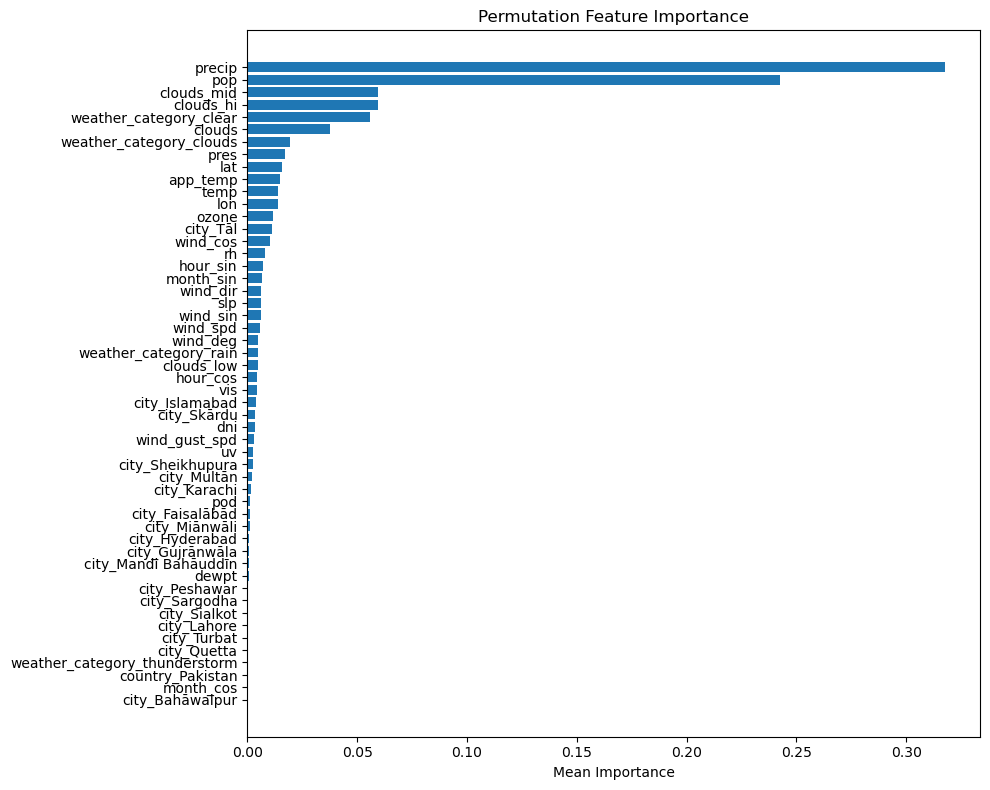

In [48]:
importance_sorted = feat_importance.sort_values(by="Importance", ascending=True)
# Plot
plt.figure(figsize=(10, 8))
plt.barh(importance_sorted['Feature'], importance_sorted['Importance'])
plt.xlabel("Mean Importance")
plt.title("Permutation Feature Importance")
plt.tight_layout()
plt.show()

In [47]:
# Set threshold
threshold = 0.003556

# Get features to keep
important_features = feat_importance[feat_importance["Importance"] >= threshold]["Feature"]

# Filter dataset
df_syn_sel = X[important_features]
df_syn_sel["rainfall"] = y

print("Original number of features:", X.shape[1])
print("Selected number of features:", df_syn_sel.shape[1])

Original number of features: 52
Selected number of features: 26


In [48]:
df_syn_sel = df_syn_sel.drop(['precip'],axis=1)

In [49]:
df_syn_sel.to_csv('D:/Machine Learning Projects/3. Rain Predictor/4_syn_sel.csv',index=False)

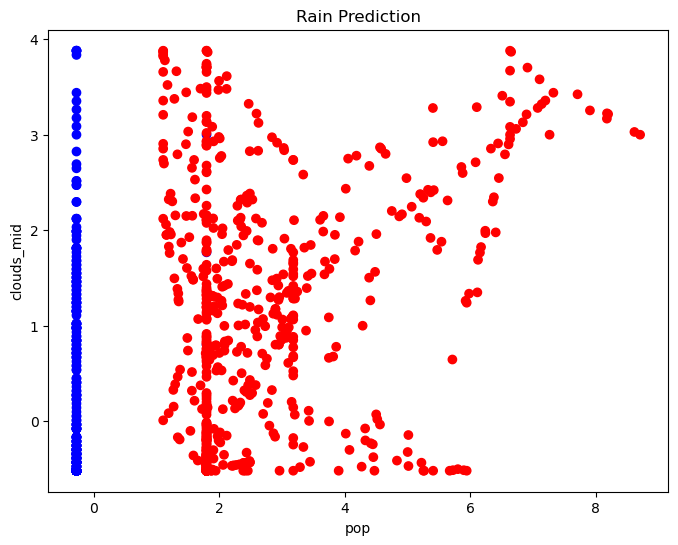

In [50]:
plt.figure(figsize=(8, 6))
plt.scatter(df_syn_sel['pop'], df_syn_sel['clouds_mid'], c=df_syn_sel['rainfall'], cmap='bwr')
plt.xlabel('pop')
plt.ylabel('clouds_mid')
plt.title('Rain Prediction')
plt.show()

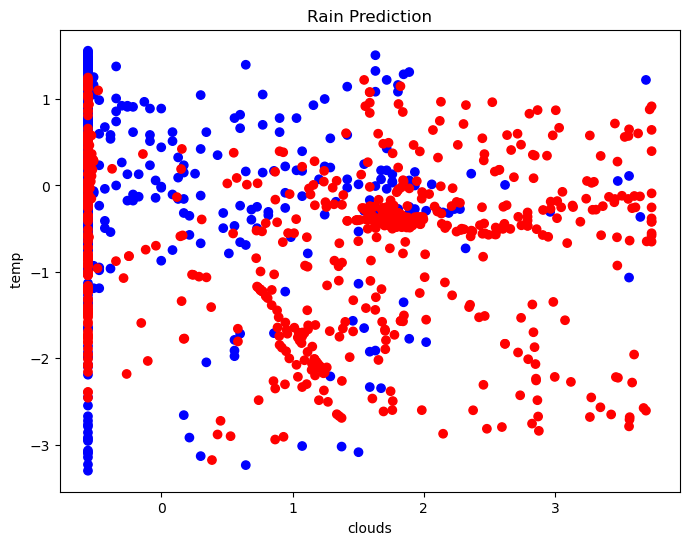

In [51]:
plt.figure(figsize=(8, 6))
plt.scatter(df_syn_sel['clouds'], df_syn_sel['temp'], c=df_syn_sel['rainfall'], cmap='bwr')
plt.xlabel('clouds')
plt.ylabel('temp    ')
plt.title('Rain Prediction')
plt.show()

In [52]:
df_syn_sel.head()

,pop,clouds_mid,clouds_hi,clouds,weather_category_clear,weather_category_clouds,wind_cos,app_temp,lat,temp,pres,rh,city_Tāl,lon,wind_sin,vis,wind_dir,weather_category_rain,slp,ozone,hour_sin,wind_spd,hour_cos,month_sin,rainfall
0,-0.276502,-0.518372,0,1.759912,0.0,1.0,-0.707107,0.295985,-2.103807,-0.331453,1.312500,1.852337,0.0,-1.456083,-0.707107,0.146721,0.387508,0.0,0.645640,-0.293695,-1.000000,1.068008,-0.000000,-1.000000,0
1,1.797264,-0.518372,0,1.716945,0.0,1.0,-0.382683,0.278430,-2.103807,-0.376954,1.279641,2.017363,0.0,-1.456083,-0.923880,0.146721,0.479079,0.0,0.475826,-0.878623,-0.707107,0.478880,0.707107,-0.707107,0
2,1.797264,-0.518372,0,1.888813,0.0,1.0,-0.707107,0.214063,-2.103807,-0.422455,1.279641,2.127380,0.0,-1.456083,-0.707107,0.146721,0.421847,0.0,0.475826,-0.460817,0.000000,0.478880,1.000000,0.000000,1
3,-0.276502,-0.518372,0,1.888813,0.0,1.0,-0.382683,0.366204,-2.103807,-0.318453,1.345360,1.907346,0.0,-1.456083,-0.923880,0.146721,0.433293,0.0,0.702245,-0.410680,0.707107,0.171509,0.707107,0.707107,0
4,-0.276502,-0.518372,0,1.931780,0.0,1.0,-0.707107,0.664635,-2.103807,0.000054,1.328930,1.192235,0.0,-1.456083,-0.707107,0.146721,0.421847,0.0,0.645640,-0.795062,1.000000,0.760637,0.000000,1.000000,0
